In [1]:
import sys
from pathlib import Path
sys.path.append("..")
import pandas as pd
import numpy as np
import jax.numpy as jnp
from numpy.fft import fft, fftshift, fftfreq
import matplotlib.pyplot as plt
from simulation.rotor import MagneticBearing3D
from simulation.pid import PID
from simulation.seal import Seal
from simulation.excitation_signals import *
from simulation.generate_dataset import *
from estimators.frequency import EIVSin

In [101]:
import numpy as np
from numpy.fft import fft, fftshift, fftfreq
import pandas as pd
from collections import Counter

class EIVSin:



    def __init__(self):
        pass

    def estimate(self, df_x, df_y, freq):

        dt = (df_x["t"] - df_y["t"].shift()).median()

        dfs = []
        for episode, group in df_x.groupby("episode"):
            temp = self.get_frequency_domain_data(df=group,
                                                  freq=freq,
                                                  dt=dt)
            temp["episode"] = episode
            dfs.append(temp)
        df_x = pd.concat(dfs, ignore_index=True)

        dfs = []
        for episode, group in df_y.groupby("episode"):
            temp = self.get_frequency_domain_data(df=group,
                                                  freq=freq,
                                                  dt=dt)
            temp["episode"] = episode
            dfs.append(temp)
        df_y = pd.concat(dfs, ignore_index=True)


        df = pd.concat([df_x, df_y], ignore_index=False)

        # Apenas frequencia de interesse
        sel_df = df[(df["freqs"] > freq - 2) & (df["freqs"] < freq + 1)].sort_index()
        # Apenas indices que exisitam no dataframe x e y
        inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(df.index).most_common()))))


        inds = list(filter(lambda  x: x in sel_df.index, inds))


        sel_df = sel_df.loc[inds]

        freq = sel_df["freqs"].unique()[0]
        print("Freq", freq, ", length", sel_df["freqs"].unique().shape)
        Us = []
        Ys = []
        for name, group in sel_df.groupby(sel_df.index):
            U = group[["xf", "yf"]].values.transpose()
            Y = group[["fxf", "fyf"]].values.transpose()
            Us.append(U)
            Ys.append(Y)
        Us = np.array(Us)
        Ys = np.array(Ys)

        G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us, axis=0))
        C = np.imag(G) / (2 * np.pi * freq)
        K = np.real(G) + (2 * np.pi * freq) ** 2 * np.array([[1, 0], [0, 1]])

        return {"freq": freq,
                "G": G,
                "C": C,
                "K": K,
                "Ys" : Ys,
                "Us" : Us}

    @staticmethod
    def _get_frequency_domain_data(df, freq, dt):
        """
        Recebe um dataframe com colunas x, y, fy e fx e retorna um dataframe com as mesmas colunas + sufixo "f"
        no dominio do tempo, alem da coluna "freqs"

        :param df: pd.DataFrame
        :param freq: float
        :param dt: float: sample interval
        :return:
        """
        N = int(np.ceil(1 / freq / dt * 2))
        
        data = {}
        data["freqs"] = []
        for n in range(df.shape[0] // N):
            data["freqs"].extend(fftshift(fftfreq(N, dt)))
        for col in ["x", "y", "fy", "fx"]:
            data[col + "f"] = []
            for n in range(df.shape[0] // N):
                data[col + "f"].extend(fftshift(fft(df[col].iloc[N * n:N * (n + 1)].values)))

        return pd.DataFrame(data)
    
    @staticmethod
    def get_frequency_domain_data(df, freq, dt):
        data={}
        for col in ["x", "y", "fy", "fx"]:
            data[col + "f"] = fftshift(fft(df[col].values))
        data["freqs"] = fftshift(fftfreq(data["xf"].shape[0], d= dt))
        return pd.DataFrame(data)

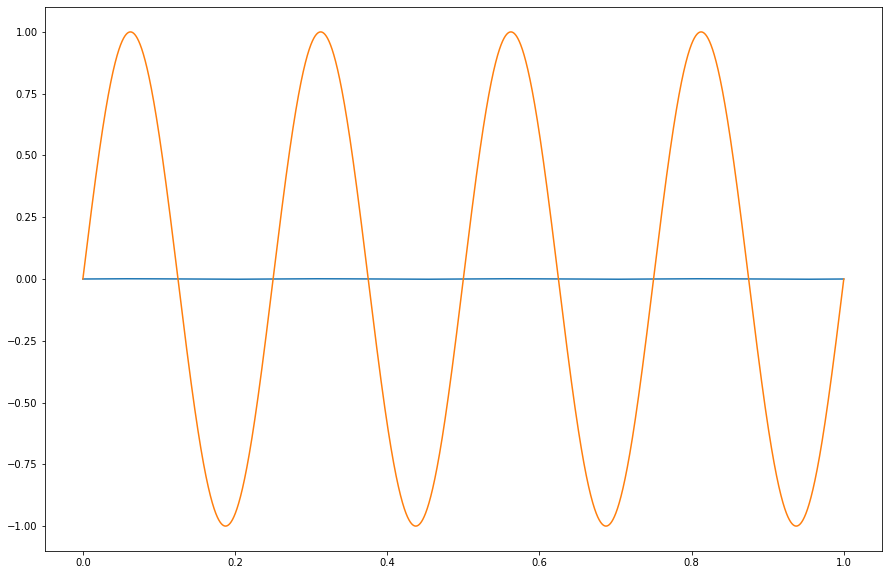

In [113]:
size= 10000
freq = 4
t = np.linspace(start=0, stop=1, num=size)
df = pd.DataFrame(dict(t=t))
df["x"] = np.sin(2*np.pi*freq*df["t"])
df["fx"] = np.sin(2*np.pi*freq*df["t"])
df["y"] = np.zeros_like(df["x"].values)
df["fy"] = np.zeros_like(df["x"].values)
df["episode"] = 0
df_x = df

df = pd.DataFrame(dict(t=t))
df["y"] = np.sin(2*np.pi*freq*df["t"])
df["fy"] = np.sin(2*np.pi*freq*df["t"])
df["x"] = np.zeros_like(df["y"].values)
df["fx"] = np.zeros_like(df["y"].values)
df["episode"] = 0
df_y = df

base = {
            "df_x" : df_x.copy(),
            "df_y" : df_y.copy(),
            "freq" : freq,
        }

df_x["x"] = df_x["x"]*0.001
df_y["y"] = df_y["y"]*0.001

exp = {
            "df_x" : df_x.copy(),
            "df_y" : df_y.copy(),
            "freq" : freq
        }


plt.figure(figsize=(15,10))
plt.plot(df_x["t"], df_x["x"])
plt.plot(df_x["t"], df_x["fx"])

In [114]:
estimator = EIVSin()
base_est = estimator.estimate(**base)
exp_est = estimator.estimate(**exp)

Freq 2.999699999999989 , length (3,)
Freq 2.999699999999989 , length (3,)


In [115]:
print(exp_est["K"] - base_est["K"])
print(exp_est["C"] - base_est["C"])

[[999.   0.]
 [  0. 999.]]
[[-2.12069689e-16  0.00000000e+00]
 [ 0.00000000e+00 -2.12069689e-16]]


In [116]:
dt = (df_x["t"] - df_x["t"].shift()).mean()
_df = EIVSin.get_frequency_domain_data(df_x, freq=freq, dt = dt)
_df.head()

,xf,yf,fyf,fxf,freqs
0,-0.000001-0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.001257+0.000000j,-4999.5000
1,-0.000001-0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.001257-0.000000j,-4998.5001
2,-0.000001-0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.001257-0.000001j,-4997.5002
3,-0.000001-0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.001257-0.000001j,-4996.5003
4,-0.000001-0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.001257-0.000002j,-4995.5004


/home/felipeangelim/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(-5.0, 5.0)

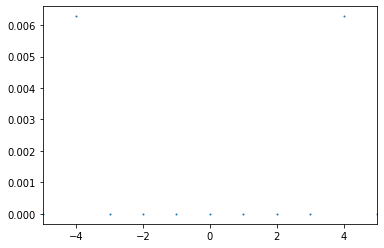

In [117]:
plt.scatter(_df["freqs"], _df["xf"], s=1)
plt.xlim(-freq-1, freq + 1)

In [99]:
dt = (df_x["t"] - df_x["t"].shift()).mean()
_df = get_frequency_domain_data(df_x, freq=freq, dt = dt)
_df.head()

,xf,yf,fyf,fxf,freqs
0,-0.006505+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.021683+0.000000j,-4999.5000
1,-0.006505-0.000002j,0.000000+0.000000j,0.000000+0.000000j,-0.021683-0.000007j,-4998.5001
2,-0.006505-0.000004j,0.000000+0.000000j,0.000000+0.000000j,-0.021683-0.000014j,-4997.5002
3,-0.006505-0.000006j,0.000000+0.000000j,0.000000+0.000000j,-0.021683-0.000020j,-4996.5003
4,-0.006505-0.000008j,0.000000+0.000000j,0.000000+0.000000j,-0.021683-0.000027j,-4995.5004


/home/felipeangelim/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(-70.0, 70.0)

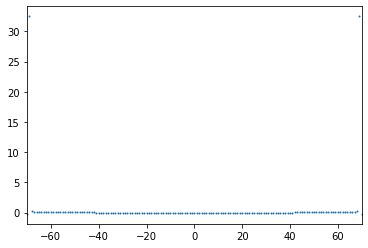

In [100]:
plt.scatter(_df["freqs"], _df["xf"], s=1)
plt.xlim(-freq-1, freq + 1)